In [22]:
import os
import json 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib

RAWPATH ='./outputs/'
# Put the "v2.jsonl" file in datasets directory 
DATADIR = './datasets/'

def plot_preds(time_series, pred_series , methods_name , uuid  , test ):
    plt.figure(figsize=(10, 6))
    plt.plot(time_series , label='Ori. Time Series',linewidth =2 , color = 'black')
    
    for loc in range(len(pred_series)):
        p = pred_series[loc]
        method_name = methods_name[loc]
        mae = round(np.mean(np.abs(p-test)) , 2) 
        plt.plot(range(len(time_series) - len(p), len(time_series)), p, label=method_name+'--mae:{}'.format(mae), linestyle='--' ,linewidth =3)
        
    test_length =  len(pred_series[0])
    train_length = len(time_series) - test_length
    
    meanP = np.array([np.mean(time_series[:train_length])] * test_length)
    plt.plot(range(train_length, len(time_series)) ,meanP, label='MP', linestyle='--')
    
    plt.xlabel('uuid : {}'.format(uuid))
    plt.ylabel('Value')
    plt.title('Time Series and forecasting results')
    plt.legend()
    plt.show()
    
def get_common_uuids():
    out_path = RAWPATH
    ojc_0 = 'gpt-4-llm_wo_context'               
    ojc_1 = 'gpt-4-llmtime_wo_context'               
    ojc_2 = 'gpt-4-llmtime_wi_Ca'                 
    ojc_3 = 'gpt-4-llmtime_wi_Ch'                
    ojc_4 = 'gpt-4-llmtime_wi_ChMe'           
    ojc_5 = 'gpt-4-llmtime_wi_CaMe'
    ojc_6 = 'gpt-4-llmtime_wi_all'     
    ojc_7 = 'gpt-4-llm_wi_all'
    
    imprs_name = [  'llm_wo_context' , 
                    'llmtime_wo_context' , 
                    'llmtime_wi_Ca' , 
                    'llmtime_wi_Ch' , 
                    'llmtime_wi_ChMe' ,
                    'llmtime_wi_CaMe' ,
                    'llmtime_wi_all' , 
                    'llm_wi_all',
            ]
    ojcs = [ojc_0 , ojc_1, ojc_2, ojc_3, ojc_4, ojc_5, ojc_6 , ojc_7]
    
    output_dirs = []
    for ojc  in ojcs:
        output_dirs.append('{}{}'.format(out_path, ojc))
        # print(ojc , os.listdir('{}{}'.format(out_path, ojc)) )
    # Keep common UUID
    common_elements = set( os.listdir(output_dirs[0]))
    for i in range(0,len(output_dirs)):
        common_elements = common_elements.intersection(set(os.listdir(output_dirs[i])))
    output_uuids = list(common_elements)
    print('# of UUID:' , len(output_uuids) )

    return output_dirs , output_uuids , imprs_name

def get_datasets(testfrac=0.2 ,  datasize = 10 ):
    data_list = pd.read_json(os.path.join(DATADIR, 'v2.jsonl'), lines=True)
    datas = []
    data_indexs =[]
    for index, row in data_list.iterrows():
        series = pd.Series(row['series'])
        splitpoint = int(len(series)*(1-testfrac))
        train = series.iloc[:splitpoint]
        test  = series.iloc[splitpoint:]
        datas.append((train, test , ''))
        data_indexs.append(row['uuid'])
        
        if index > datasize : break
    datasets = dict(zip(data_indexs,datas))
    return datasets
    
def draw_predict_curves(number_of_plots=10):
    output_dirs , output_uuids , methods_name = get_common_uuids()
    datasets =  get_datasets()
    assert len(output_dirs) == len(methods_name)
    model= 'gpt-4'
    count_plts =1
    for ds_name in datasets.keys() : 
        uuid = str(ds_name.split(".")[0])
        if uuid+'.pkl' not in output_uuids : 
            continue 
        preds =[]
        for idx in range(len(output_dirs)): 
            output_dir = output_dirs[idx]
            
            with open(f'{output_dir}/{uuid}.pkl', 'rb') as f:
                out = pickle.load(f)
                
            train , test , _ = datasets[uuid]
            time_series = np.append(train.values , test.values , 0)
            pred = out[model]['median'].values
            assert len(pred) == len(test)
            preds.append(pred)
            
        plot_preds(time_series, preds , methods_name ,uuid , test )
        count_plts +=1 
        if count_plts > number_of_plots : break 

# of UUID: 1


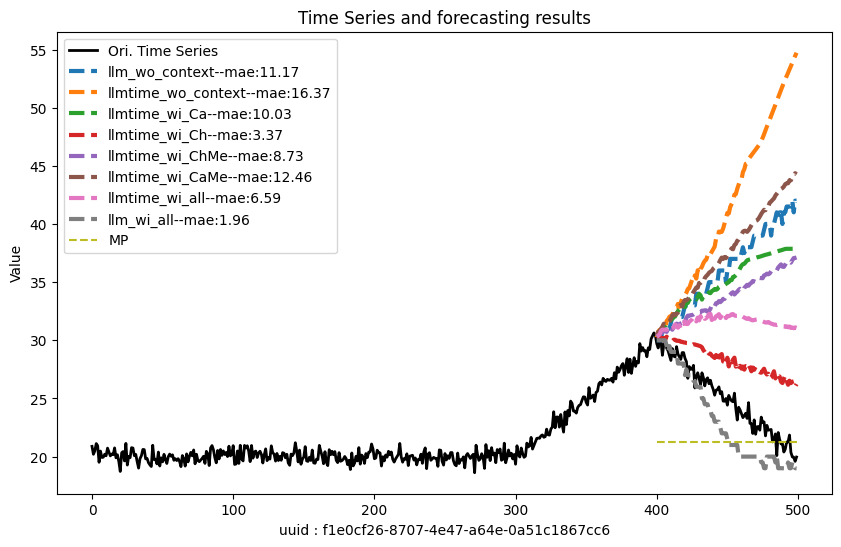

In [23]:
draw_predict_curves(number_of_plots=1)